In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as function
from torchvision import datasets,transforms
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd

if torch.cuda.is_available()==False:
    raise ImportError


In [18]:
picture_width=178
picture_height=218 #the width and height of picture in celeba
#待会儿改成可以除以4的，比如54*4=216
classesNum=2 #male or female
epochs=3 #how much epoch I need to run
batch_size0 =6 #I want to train it with minibatch.
#there are 5000 images in celeba dataset
img_path=os.getcwd()[:-2]+"Datasets\\celeba" #[:-2]for delet "A1"

feature_size=14
#I will double the feature_size after every pooling layer.so if you set feature_size to a very big number,
#It will become very slow

In [19]:
#this class is for loading data.
class DatasetCreater(Dataset):
    def __init__(self,path:str,start_item:int,data_size:int,data_format:str,transformer:object):
        #transformer is an object created by torchvision.transforms.Compose()to transform an picture from PIL object to tensor
        super().__init__()
        self.path=path
        self.start_item=start_item
        self.data_size=data_size
        self.transformer=transformer
        self.data_format=data_format
            
        #we process labels.Labels are small so I want to load every labes in the initial process
        #pictures are big so I want to load it when I need to use it
        labelPath=self.path+'\\labels.csv'
        self.labels=pd.read_csv(labelPath)
        self.labelsNew=[]
        
        for row in self.labels.iterrows():
        #self.labels is a Dataframe,we can only use .iterrows()method to iter a dataframe
            Name_index = str(row).find("Name")
            self.labelsNew.append(0 if str(row)[Name_index-3]=="-" else 1)
       # we change ”-1“ to 0 and change ”1“ to 1 ,0 represents "not smiling" and 1 repersents "smiling"
        #现在我有一个imgs的数组，这个数组里面每一个元素都是一个图片tensor

    def __len__(self):
        return self.data_size
    #哈哈，枚举类型和for循环也不知道可迭代对象有几个元素。他们就是通过__len__()函数找要迭代多少次的。如果__len__函数大于
    #真实可迭代次数，就会报错
    
    def __getitem__(self, item):
        #the path of one data
        OneDataPath=self.path+"\\img\\"+str(item+self.start_item)+"."+self.data_format
        image=Image.open(OneDataPath).convert('RGB')
        imageTensor=self.transformer(image)

        label=self.labelsNew[item+self.start_item]
        return imageTensor,label

transformer_train = transforms.Compose(
    [
   # transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.1),#随机水平翻转 选择一个概率概率 randon horizontal Flip
    # transforms.RandomVerticalFlip(p=0.2),#随机垂直翻转 I have tested this function,the performance is not good.
    #Because there is no need to identify head-down photos in the dataset and the tasks we need to complete
    #transforms.RandomRotation(30),#随机旋转，-45到45度之间随机选
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])         
])

transformer_test = transforms.Compose(
    [
   # transforms.Resize((256,256)),
    # transforms.RandomHorizontalFlip(p=0.2),#随机水平翻转 选择一个概率概率 randon horizontal Flip
    # transforms.RandomVerticalFlip(p=0.2),#随机垂直翻转
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])         
])

train_data=DatasetCreater(img_path,0,4000,"jpg",transformer_train)
train_loader =DataLoader(
	dataset=train_data,
    batch_size=batch_size0,
    shuffle=True
	)
test_data=DatasetCreater(img_path,4000,1000,"jpg",transformer_test)

test_loader =DataLoader(
	dataset=test_data,
    batch_size=batch_size0,
    shuffle=True
	)

In [20]:
#DatasetCreater_Testfunction
#a.__getitem__(2) #male
#a.__getitem__(4999) #female
# Flag=0
# for i,j in test_loader:
# 	print(i)
# 	break
    
#什么是枚举函数呢？实际上enumerate函数自动调用了对象的__getitem__()方法，将其的每个输出对应一个序号，以index，value的形式进行枚举
#无论是for还是枚举函数，什么时候停止迭代呢

In [21]:
#now ,I want to creat a neural network
class ConvolutionalNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.convModule=nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            #nn.BatchNorm2d(feature_size),
            nn.ReLU(),
             nn.Conv2d(
                in_channels=feature_size,
                out_channels=feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size,
                out_channels=2*feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            #nn.BatchNorm2d(2*feature_size),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=2*feature_size,
                out_channels=2*feature_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(2*feature_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # self.conv3=nn.Sequential(
        #     nn.Conv2d(
        #         in_channels=20,
        #         out_channels=20,
        #         kernel_size=3,
        #         stride=1,
        #         padding=1
        #     ),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        #)
        self.outLayer=nn.Sequential(
            nn.Linear(66528,1000),
            nn.ReLU(),
            nn.Linear(1000,2)
            )
         #10 feature maps
        #this number 28512 is not good,I don't know how the outLayer number should be set
        #So If you change the input size of the picture,this neural net work will raise a 
        #error which is "mat1 and mat2 shapes cannot be multiplied (10x aNnumber and 28512x2)""
        #then,you should change 28512 to "aNumber"in there
        #216/2/2=54 pooling twice，male&female，2output
    
    def forward(self,input):
        input1=self.convModule(input)
        input2=self.conv2(input1)
        #input3=self.conv3(input2)
        
        input4=input2.view(input2.size(0),-1)
        output=self.outLayer(input4)
        return output
        #we want to reshape the fature map into a vector

In [22]:
# def precision(predict_solution, labels):
#     pred = torch.max(predict_solution.data, 1)[1] 
#     #torch.max()function return the biggest value of each row or column. if the 
#     # second argument is 0,group by column;if the second argument is 1,group by row
#     # so torch.max(predict_solution, 1) return a 
#     rights = pred.eq(labels.data.view_as(pred)).sum() 
#     return rights, len(labels) 
def precision(predict_solution,labels):
    pred = torch.max(predict_solution.data, 1)[1]
    number_of_right=0
    for label,value in enumerate(pred):
        if value==labels[label]:
            number_of_right+=1
    return number_of_right/len(labels)

In [23]:
def parameter_selection(Ir):
        neuroNet=ConvolutionalNN().cuda()
        #next,I  define a loss function and an optimizer
        lossFunction=nn.CrossEntropyLoss()
        #Cross Entropy loss is linked to mutiple classification problems，one-hot label
        optimizer = optim.Adam(neuroNet.parameters(), Ir)
        #Adam and Nadam are the best
        #later,I want to choose the best Ir by model selection
        flag=0#flag for training times
        test_rights=[]
        training_batch_times=[]
        for i in range(epochs):
                # flag=0
                # #test_flag=0
                # test_loader__iter=test_loader.__iter__()
                #an iter of test_loader
                
                for bach,label in train_loader: 
                        
                        
                        neuroNet.train()#set the test_loader_iter neural network to training model                        
                        output = neuroNet(bach.cuda())
                        loss = lossFunction(output,label.cuda())

                        flag+=1
                        if flag%50==0:
                                # neuroNet.eval()
                                # print("training times=",flag)
                                torch.cuda.empty_cache()
                                test_batchs_number=0
                                sum_of_precision=0
                                for i,j in test_loader:
                                        sum_of_precision+=precision(neuroNet(i.cuda()).cpu(),j)
                                        test_batchs_number+=1
                                test_right=sum_of_precision/test_batchs_number
                                print(test_right)
                                test_rights.append(test_right)
                                training_batch_times.append(flag)
                                if flag>=500:
                                        if test_right==max(test_rights) and test_right>0.85:
                                                return neuroNet,test_rights,training_batch_times
                        optimizer.zero_grad()#clean the grade 
                        loss.backward()
                        
                        optimizer.step()
        return neuroNet,test_rights,training_batch_times
                # if flag%300==0:#
                #         neuroNet.eval()#evaluate
                #         train_right = precision(output, label)
                #         train_rights.append(train_right)
                #         test_data,test_label= next(test_loader__iter)
                #         output = neuroNet(test_data) 
                #         test_right = precision(output, test_label) 
                #         test_rights.append(test_right)
                # print("train_rights=",train_rights[0],"test_rights=",test_rights[0])



                        
                 



In [24]:
#now,we want to select the best Ir and other parameters for our module
# # for Ir in [0.001,0.0012,0.0014,0.0016]:
# neuroNet,test_rights,training_batch_times=parameter_selection(0.0013)




0.6132734530938123
0.44960079840319367
0.560878243512974
0.7030938123752494
0.7215568862275448
0.7400199600798403
0.6417165668662675
0.7659680638722551
0.7195608782435127
0.7524950099800398
0.7819361277445107
0.7549900199600799
0.764970059880239
0.8123752495009979
0.7849301397205586
0.8213572854291414
0.8063872255489016
0.8093812375249498
0.7694610778443111
0.772954091816367
0.8203592814371258
0.8073852295409184
0.8133732534930135
0.7929141716566864
0.8198602794411178
0.8368263473053894
0.8517964071856288


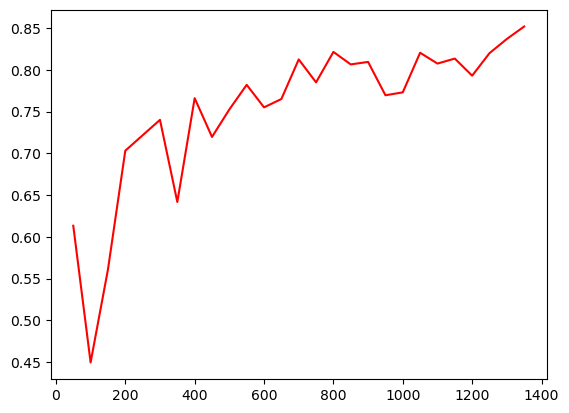

In [25]:
# plt.plot(training_batch_times, test_rights,c = 'r')

In [26]:
torch.save(neuroNet.state_dict(), "./model_parameter.pkl")

trained_model=ConvolutionalNN()
trained_model.load_state_dict(torch.load("./model_parameter.pkl"))
test_batchs_number=0
sum_of_precision=0
for i,j in test_loader:
        sum_of_precision+=precision(trained_model(i),j)
        test_batchs_number+=1
        test_right=sum_of_precision/test_batchs_number
print(test_right)

0.8453093812375245
